# Prediksi Status Gizi Anak Menggunakan Support Vector Machine (SVM) dan K-Nearest Neighbor (KNN)
Penelitian ini menggunakan dataset Stunting Baby/Toddler Detection yang diakses pada https://www.kaggle.com/datasets/rendiputra/stunting-balita-detection-121k-rows yang terdiri dari 121.000 baris dengan 4 atribut diantaranya Umur (bulan), Jenis Kelamin, Tinggi Badan (cm), dan Status Gizi.

# Import Package

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from dython.nominal import associations
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix

import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn import svm

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
df = pd.read_excel(r"D:\Riset\SENADA\data_stunting_senada.xlsx") 
df

,Umur (bulan),Jenis Kelamin,Tinggi Badan (cm),Status Gizi
0,0,laki-laki,44.591973,stunted
1,0,laki-laki,56.705203,tinggi
2,0,laki-laki,46.863358,normal
3,0,laki-laki,47.508026,normal
4,0,laki-laki,42.743494,severely stunted
...,...,...,...,...
120994,60,perempuan,100.600000,normal
120995,60,perempuan,98.300000,stunted
120996,60,perempuan,121.300000,normal
120997,60,perempuan,112.200000,normal


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120999 entries, 0 to 120998
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Umur (bulan)       120999 non-null  int64  
 1   Jenis Kelamin      120999 non-null  object 
 2   Tinggi Badan (cm)  120999 non-null  float64
 3   Status Gizi        120999 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 3.7+ MB


In [ ]:
df

,Umur (bulan),Jenis Kelamin,Tinggi Badan (cm),Status Gizi
0,0,laki-laki,44.591973,stunted
1,0,laki-laki,56.705203,tinggi
2,0,laki-laki,46.863358,normal
3,0,laki-laki,47.508026,normal
4,0,laki-laki,42.743494,severely stunted
...,...,...,...,...
120994,60,perempuan,100.600000,normal
120995,60,perempuan,98.300000,stunted
120996,60,perempuan,121.300000,normal
120997,60,perempuan,112.200000,normal


In [ ]:
df

,Umur (bulan),Jenis Kelamin,Tinggi Badan (cm),Status Gizi
0,0,laki-laki,44.591973,stunted
1,0,laki-laki,56.705203,tinggi
2,0,laki-laki,46.863358,normal
3,0,laki-laki,47.508026,normal
4,0,laki-laki,42.743494,severely stunted
...,...,...,...,...
120994,60,perempuan,100.600000,normal
120995,60,perempuan,98.300000,stunted
120996,60,perempuan,121.300000,normal
120997,60,perempuan,112.200000,normal


# Data Cleaning

In [6]:
import pandas as pd

# Mengganti df dengan nama DataFrame Anda
df = df.sample(n=10000, random_state=42)

# Menampilkan ukuran DataFrame yang sudah diambil sampel
print("Ukuran DataFrame setelah diambil sampel:", df.shape)

Ukuran DataFrame setelah diambil sampel: (10000, 4)


In [7]:
dr= pd.DataFrame({
    "type":df.dtypes.values,
    "null":df.isnull().sum().values,
    "null_percentage": ["{:.2f}%".format(val) for val in df.isnull().sum().values / len(df) * 100],
    "unique":[df[i].nunique() for i in df.columns],
    "duplicated": df.duplicated().sum(),
    "sample":[list(pd.Series(df.dropna()[i].unique()).sample())[0] for i in df.columns]
}).set_index(df.isnull().sum().index).sort_values("null",ascending=False)
dr

,type,null,null_percentage,unique,duplicated,sample
Umur (bulan),int64,0,0.00%,61,1178,44
Jenis Kelamin,object,0,0.00%,2,1178,perempuan
Tinggi Badan (cm),float64,0,0.00%,1272,1178,56.875524
Status Gizi,object,0,0.00%,4,1178,stunted


Terdapat data yang duplikat. Data duplikat dapat mengganggu analisis dan membuat model menjadi bias karena memberikan bobot yang tidak proporsional terhadap observasi yang sama.

In [8]:
df.drop_duplicates(inplace=True)
dr

,type,null,null_percentage,unique,duplicated,sample
Umur (bulan),int64,0,0.00%,61,1178,44
Jenis Kelamin,object,0,0.00%,2,1178,perempuan
Tinggi Badan (cm),float64,0,0.00%,1272,1178,56.875524
Status Gizi,object,0,0.00%,4,1178,stunted


# Eksplorasi Data

In [9]:
df.describe()

,Umur (bulan),Tinggi Badan (cm)
count,8822.000000,8822.000000
mean,29.612333,88.110344
std,17.594863,17.443622
min,0.000000,40.080841
25%,15.000000,76.500000
50%,30.000000,89.200000
75%,45.000000,100.700000
max,60.000000,127.800000


In [10]:
dc = df.copy()

In [11]:
#Membuat variabel kategori untuk  tipe data category dan boolean
kategori = dc.select_dtypes(include=['object']).columns.values

In [12]:
# encode variabel kategori
label_encoder = LabelEncoder()
for cols in kategori:
    dc[cols] = label_encoder.fit_transform(dc[cols])
dc

,Umur (bulan),Jenis Kelamin,Tinggi Badan (cm),Status Gizi
17917,8,1,70.1,0
6976,3,0,65.4,0
37592,19,0,72.9,1
89657,45,0,89.1,1
117023,59,0,94.0,1
...,...,...,...,...
6717,3,0,62.9,0
15663,7,1,70.2,0
21196,11,0,76.4,0
88975,44,1,100.4,0


In [13]:
dc.describe()

,Umur (bulan),Jenis Kelamin,Tinggi Badan (cm),Status Gizi
count,8822.000000,8822.000000,8822.000000,8822.000000
mean,29.612333,0.498753,88.110344,0.892315
std,17.594863,0.500027,17.443622,1.147134
min,0.000000,0.000000,40.080841,0.000000
25%,15.000000,0.000000,76.500000,0.000000
50%,30.000000,0.000000,89.200000,0.000000
75%,45.000000,1.000000,100.700000,2.000000
max,60.000000,1.000000,127.800000,3.000000


Umur rata-rata anak dalam dataset adalah sekitar 28 bulan, dengan rentang umur dari bayi baru lahir hingga 5 tahun. 
Tinggi badan rata-rata anak adalah sekitar 86 cm, dengan variasi tinggi badan yang relatif besar, mulai dari 40 cm hingga 128 cm.

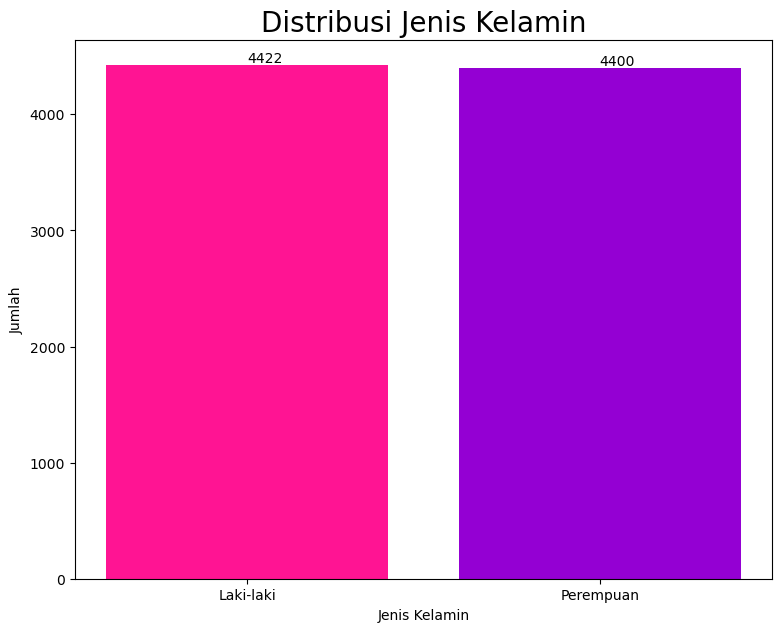

In [14]:
# Mapping numeric values to descriptive labels
status_labels = {
    0: 'Laki-laki',
    1: 'Perempuan',
}

# Assuming 'df' is your DataFrame and 'Jenis Kelamin' is the column with categories
status_counts = dc['Jenis Kelamin'].value_counts().sort_index()

# If 'status_labels' is a dictionary mapping index to labels
labels = [status_labels[i] for i in status_counts.index]

# Defining colors
colors = ['deeppink', 'darkviolet', 'hotpink', 'mediumorchid', 'plum']  # Add more colors if needed

# Plotting bar chart
plt.figure(figsize=(9, 7))
bars = plt.bar(labels, status_counts, color=colors[:len(labels)])

# Adding counts on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, yval, int(yval), va='bottom')  # int(yval) converts count to integer

plt.xlabel('Jenis Kelamin')
plt.ylabel('Jumlah')
plt.title('Distribusi Jenis Kelamin', fontsize=20)
plt.show()

Dari plot, terlihat bahwa jumlah data untuk jenis kelamin perempuan lebih banyak daripada laki-laki. Meskipun perbedaannya cukup signifikan, namun perbedaan ini tidak terlalu jauh atau tidak signifikan secara statistik. Hal ini menunjukkan bahwa distribusi jenis kelamin dalam dataset relatif seimbang dan tidak menunjukkan adanya bias yang signifikan dalam hal jumlah antara perempuan dan laki-laki.

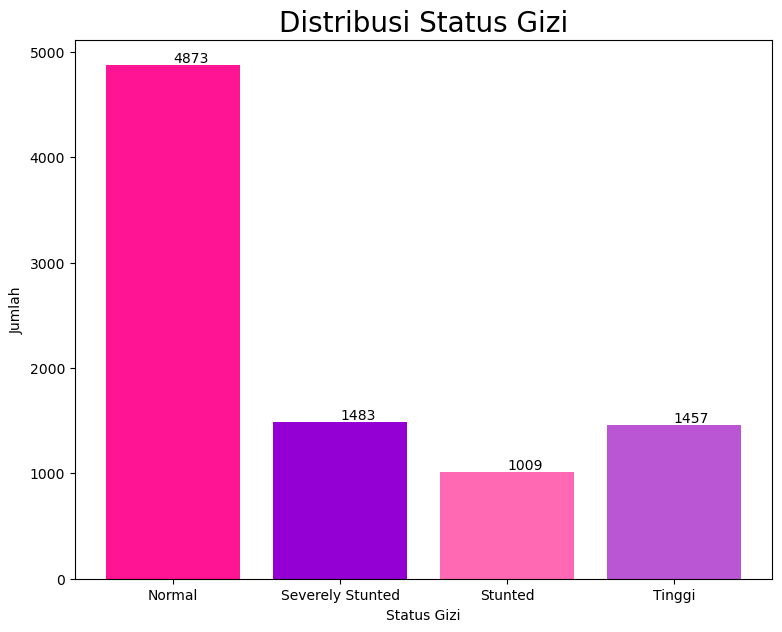

In [15]:
# Mapping numeric values to descriptive labels
status_labels = {
    0: 'Normal',
    1: 'Severely Stunted',
    2: 'Stunted',
    3: 'Tinggi'
}

# Assuming 'df' is your DataFrame and 'Status Gizi' is the column with categories
status_counts_gizi = dc['Status Gizi'].value_counts().sort_index()

# If 'status_labels' is a dictionary mapping index to labels
labels_gizi = [status_labels[i] for i in status_counts_gizi.index]

# Defining colors
colors_gizi = ['deeppink', 'darkviolet', 'hotpink', 'mediumorchid', 'plum']  # Add more colors if needed

# Plotting bar chart for 'Status Gizi'
plt.figure(figsize=(9, 7))
bars_gizi = plt.bar(labels_gizi, status_counts_gizi, color=colors_gizi[:len(labels_gizi)])

# Adding counts on top of each bar
for bar in bars_gizi:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, yval, int(yval), va='bottom')  # int(yval) converts count to integer

plt.xlabel('Status Gizi')
plt.ylabel('Jumlah')
plt.title('Distribusi Status Gizi', fontsize=20)
plt.show()

Data ini memberikan gambaran tentang prevalensi status gizi anak dalam dataset Anda, dengan jumlah terbanyak dimiliki oleh anak-anak dengan status gizi "Normal". Sedangkan jumlah anak dengan stunting, baik yang parah maupun ringan, juga tercatat dalam jumlah yang signifikan. 

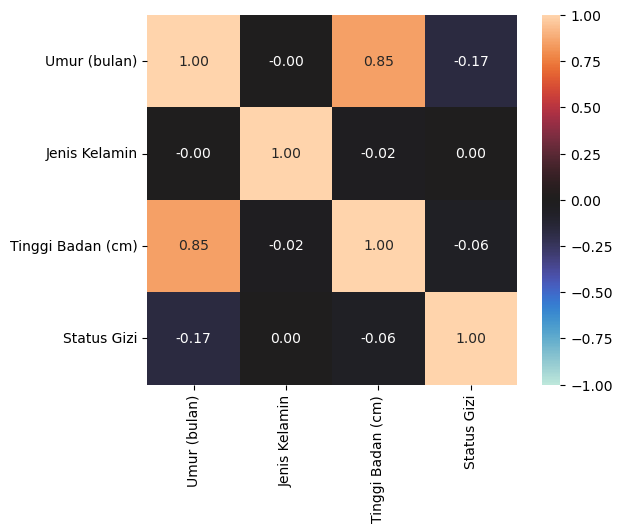

In [16]:
#plotting heatmap dengan correlation pada dc
corr = associations(dc)

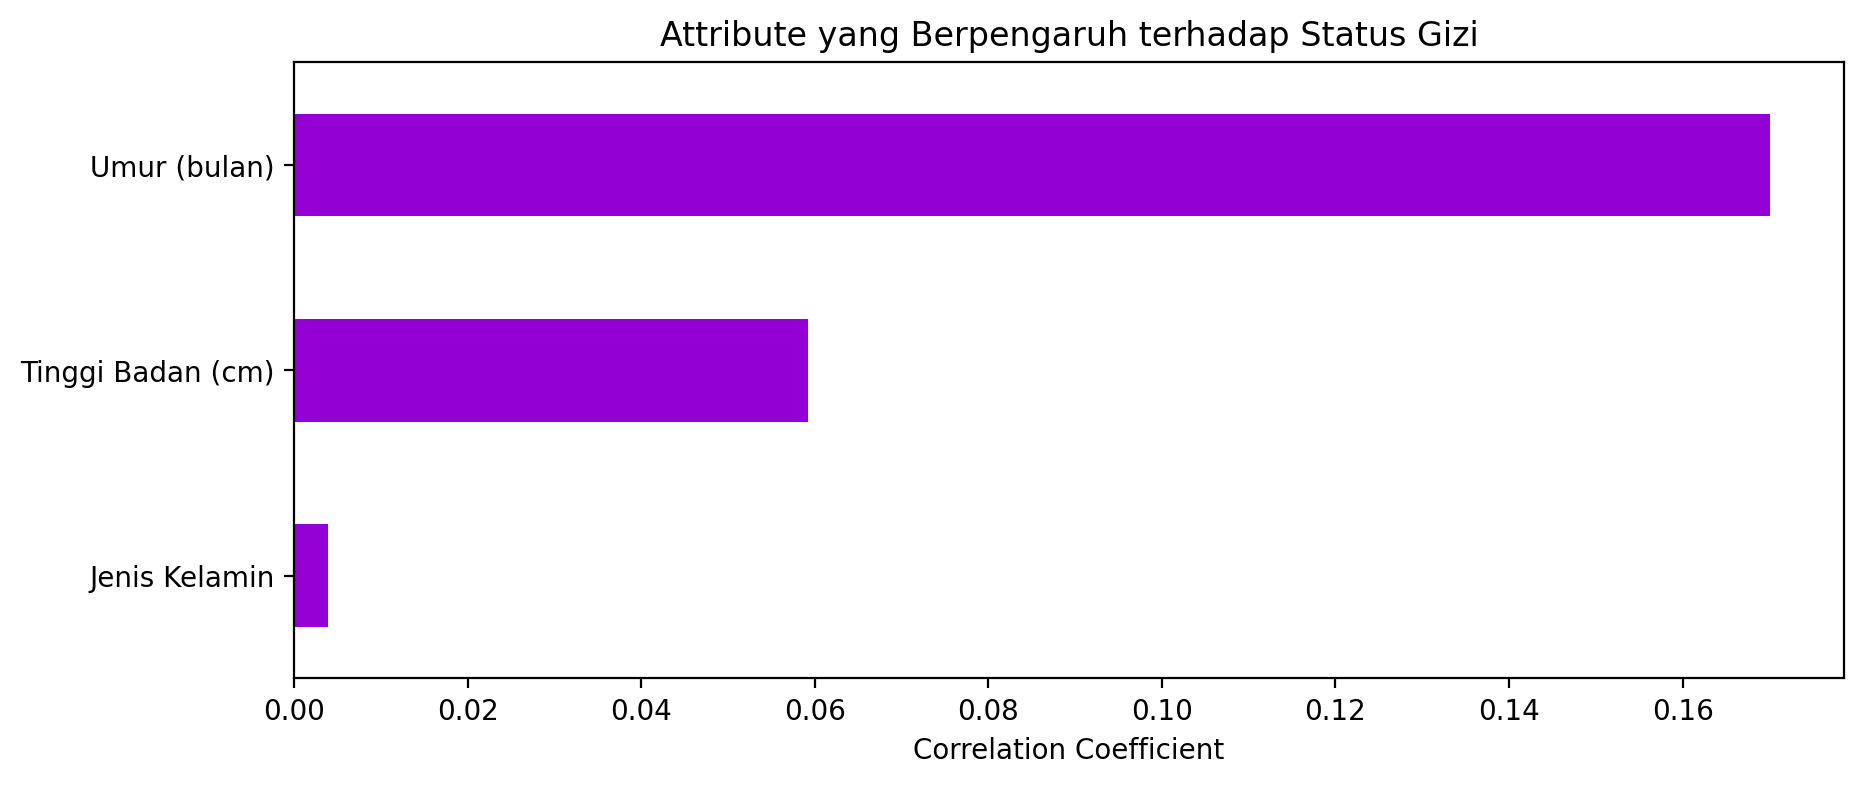

In [17]:
top_corr = abs(corr["corr"][["Status Gizi"]].drop("Status Gizi")).sort_values("Status Gizi",ascending=False)

fig = plt.figure(figsize=(10,4),dpi=200)
top_corr.sort_values("Status Gizi").plot(
    kind="barh",
    legend=None,
    color="darkviolet",
    ax=plt.gca()
)
plt.title("Attribute yang Berpengaruh terhadap Status Gizi")
plt.xlabel("Correlation Coefficient")
plt.show()

Variabel yang paling berpengaruh terhadap status gizi adalah Umur.

# Data Preprocessing

In [18]:
# Defenisiskan data
X= dc.drop('Status Gizi', axis=1)
y= dc['Status Gizi']

In [19]:
# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=100)

In [20]:
# Melakukan proses scaling pada variabel prediktor
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [21]:
# Cetak jumlah data pada masing-masing set
print('Shape of X:', X.shape)
print('Shape of Y:', y.shape)
print("Shape of X Train: ", X_train_scaled.shape)
print("Shape of Y Train: ", y_train.shape)
print("Shape of X Test: ", X_test_scaled.shape)
print("Shape of Y Test: ", y_test.shape)

Shape of X: (8822, 3)
Shape of Y: (8822,)
Shape of X Train:  (7057, 3)
Shape of Y Train:  (7057,)
Shape of X Test:  (1765, 3)
Shape of Y Test:  (1765,)


# Support Vector Machine

In [22]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# Data preprocessing (normalization, feature selection)

# Define the SVM model
svm_model = SVC(kernel='rbf')

# Define the parameters for Grid Search
param_grid = {'C': [0.1, 1, 10],
              'gamma': ['scale', 'auto']}

In [23]:
# Perform Grid Search with cross-validation
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']})

In [24]:
# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

Best parameters: {'C': 10, 'gamma': 'scale'}


In [25]:
# Evaluate the model with best parameters
best_svm_model = grid_search.best_estimator_
y_pred_svm = best_svm_model.predict(X_test_scaled)

# Print classification report and confusion matrix
print(classification_report(y_test, y_pred_svm))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       942
           1       0.98      0.98      0.98       331
           2       0.94      0.91      0.92       197
           3       0.97      0.97      0.97       295

    accuracy                           0.97      1765
   macro avg       0.96      0.96      0.96      1765
weighted avg       0.97      0.97      0.97      1765

Confusion Matrix:
[[926   1   5  10]
 [  0 324   7   0]
 [ 11   7 179   0]
 [ 10   0   0 285]]


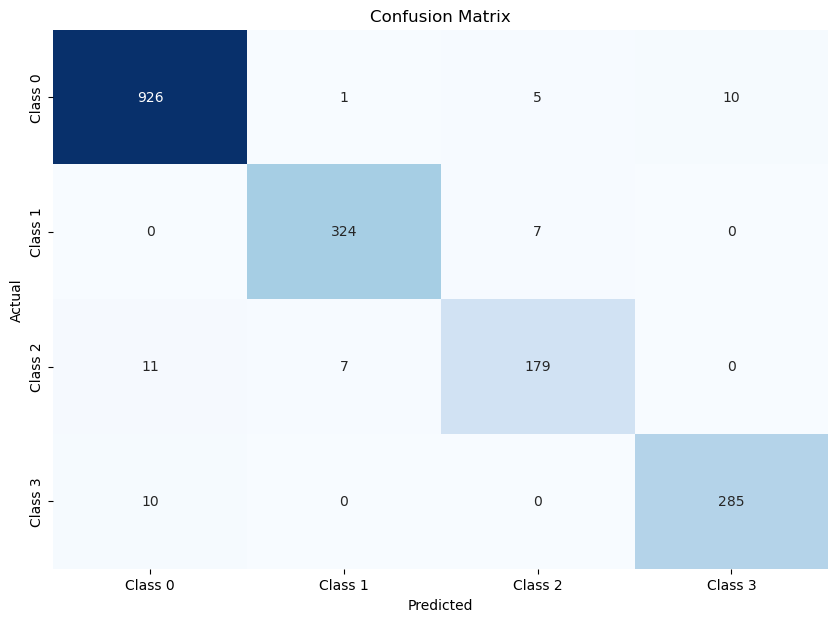

In [26]:
#Confusion matrix
cm = confusion_matrix(y_test, y_pred_svm)

# Create a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'], 
            yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [27]:
# summary model
print('\n\n')
print(classification_report(y_test, y_pred_svm))




              precision    recall  f1-score   support

           0       0.98      0.98      0.98       942
           1       0.98      0.98      0.98       331
           2       0.94      0.91      0.92       197
           3       0.97      0.97      0.97       295

    accuracy                           0.97      1765
   macro avg       0.96      0.96      0.96      1765
weighted avg       0.97      0.97      0.97      1765



Dari hasil di atas, dapat dilihat bahwa model memiliki kinerja yang sangat baik, dengan nilai precision, recall, dan f1-score yang tinggi untuk setiap kelas. Akurasi juga tinggi sebesar 96.00%, menunjukkan bahwa model secara keseluruhan sangat baik dalam melakukan prediksi.

# K-Nearest Neighbor

In [28]:
from sklearn.neighbors import KNeighborsClassifier

In [29]:
# List untuk menyimpan skor cross-validation untuk setiap nilai K
cv_scores = []

# Range nilai K yang akan diuji
k_range = range(1, 11)

In [31]:
from sklearn.model_selection import cross_val_score

# Melakukan cross-validation untuk setiap nilai K
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

In [32]:
# Mencari nilai K dengan performa terbaik
optimal_k = k_range[np.argmax(cv_scores)]
print("Optimal K:", optimal_k)

Optimal K: 1


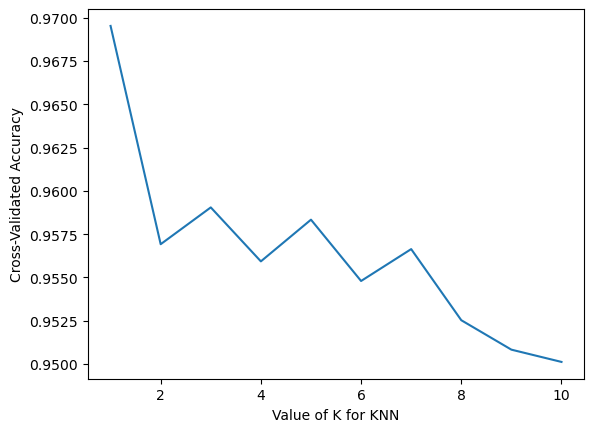

In [33]:
# Plot hasil cross-validation
import matplotlib.pyplot as plt
plt.plot(k_range, cv_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

In [34]:
# Inisialisasi model KNN dengan k neighbors yang diinginkan
k = 1  # Jumlah tetangga yang akan dipertimbangkan
knn = KNeighborsClassifier(n_neighbors=k)

In [35]:
# Train model menggunakan training sets
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=1)

In [36]:
# Melakukan prediksi pada set pengujian
y_pred_knn = knn.predict(X_test_scaled)

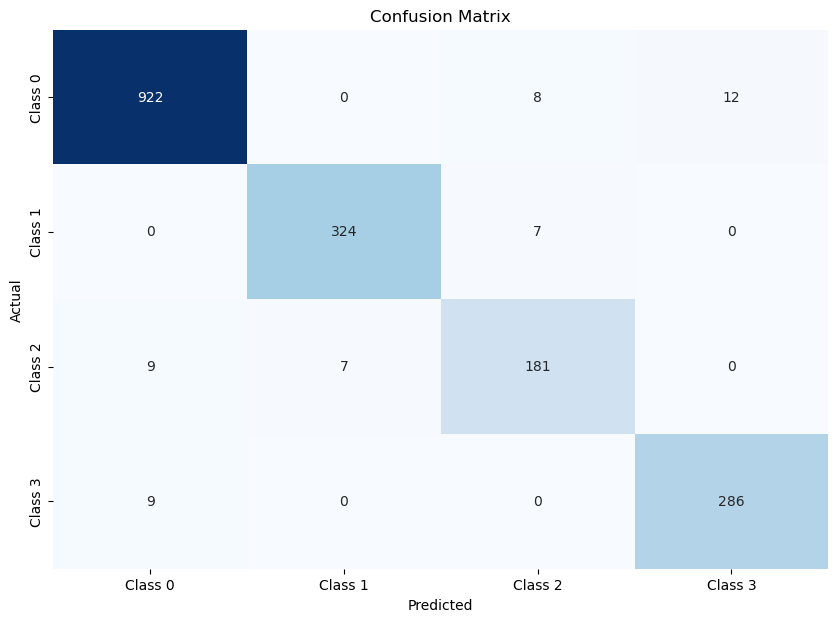

In [37]:
#Confusion matrix
cm_knn = confusion_matrix(y_test, y_pred_knn)

# Create a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'],
            yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [38]:
# summary model
print('\n\n')
print(classification_report(y_test, y_pred_knn))




              precision    recall  f1-score   support

           0       0.98      0.98      0.98       942
           1       0.98      0.98      0.98       331
           2       0.92      0.92      0.92       197
           3       0.96      0.97      0.96       295

    accuracy                           0.97      1765
   macro avg       0.96      0.96      0.96      1765
weighted avg       0.97      0.97      0.97      1765



Dari hasil di atas, dapat dilihat bahwa model memiliki kinerja yang sangat baik, dengan nilai precision, recall, dan f1-score yang tinggi untuk setiap kelas. Akurasi juga tinggi sebesar 99.00%, menunjukkan bahwa model secara keseluruhan sangat baik dalam melakukan prediksi

# Evaluation Model

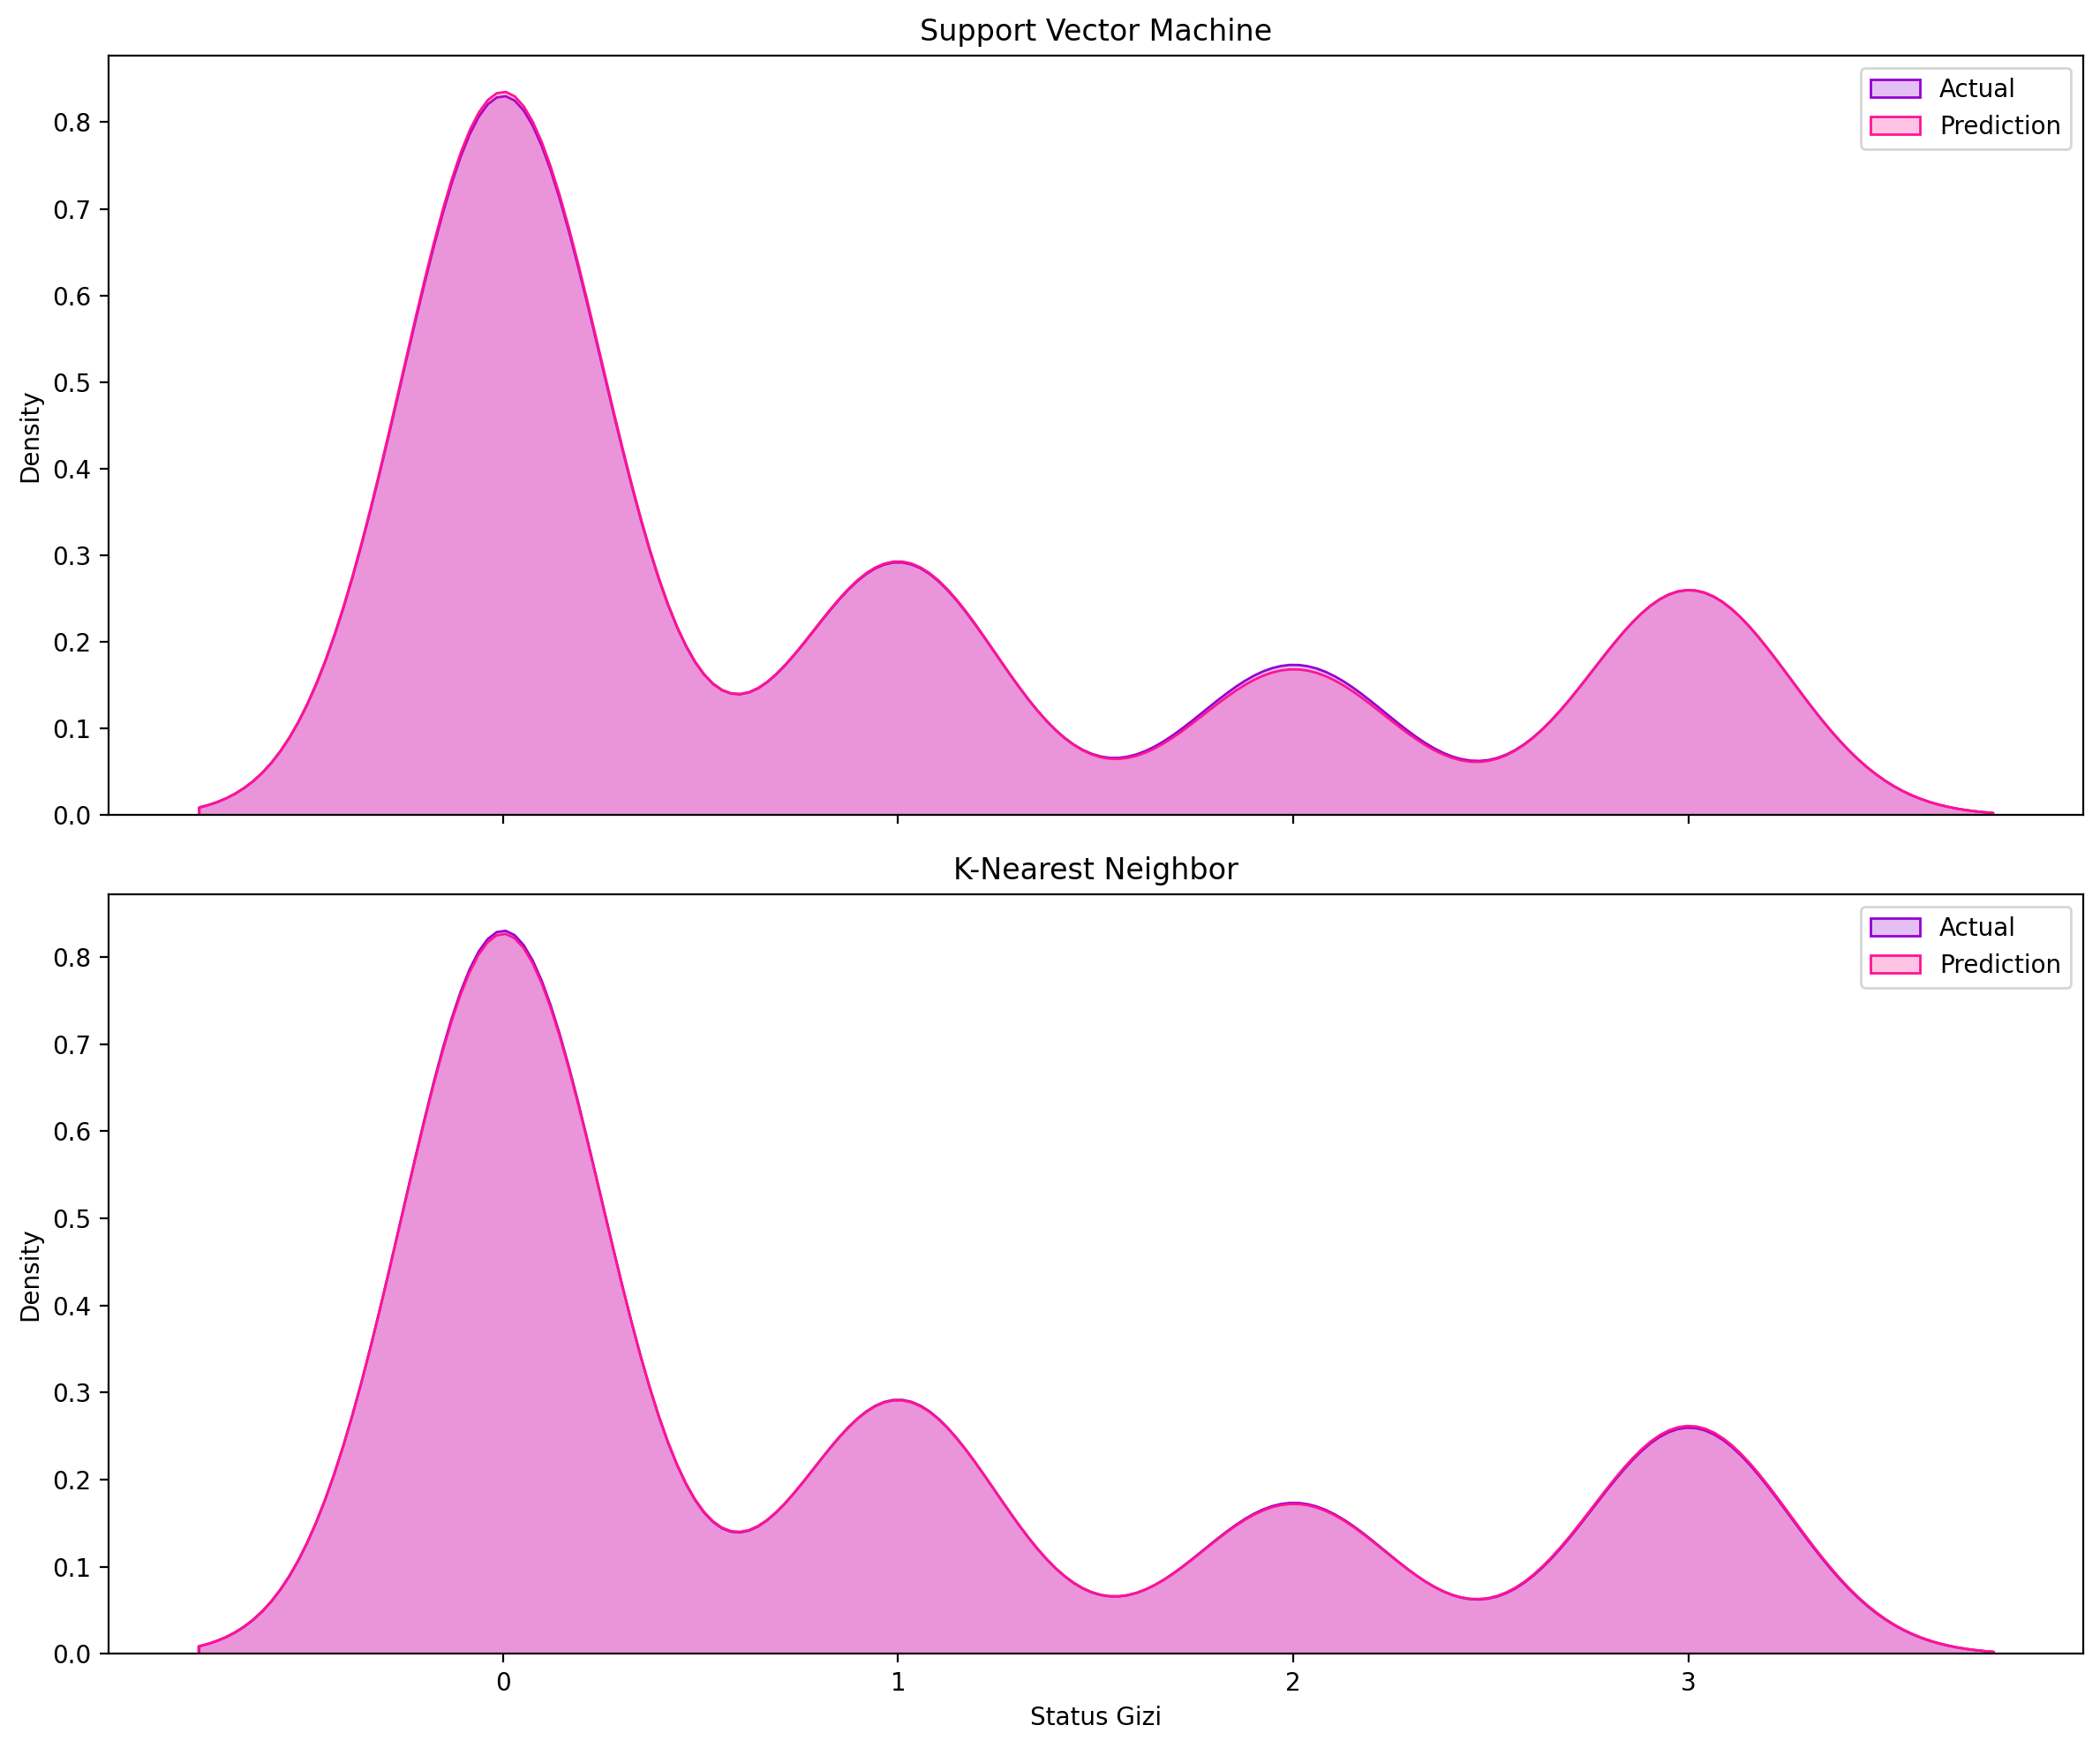

In [39]:
fig,ax = plt.subplots(figsize=(12,10),dpi=200,nrows=2,ncols=1,sharex=True)

sns.kdeplot(y_test,color="darkviolet",fill=True,label="Actual",ax=ax[0])
sns.kdeplot(y_pred_svm,color="deeppink",fill=True,label="Prediction",ax=ax[0])
ax[0].set_title("Support Vector Machine")
ax[0].set_xlabel("Status Gizi")
ax[0].legend(loc="upper right")

sns.kdeplot(y_test,color="darkviolet",fill=True,label="Actual",ax=ax[1])
sns.kdeplot(y_pred_knn,color="deeppink",fill=True,label="Prediction",ax=ax[1])
ax[1].set_title("K-Nearest Neighbor")
ax[1].set_xlabel("Status Gizi")
ax[1].legend(loc="upper right")

plt.tight_layout()
plt.show()

KNN menunjukkan prediksi yang paling akurat.

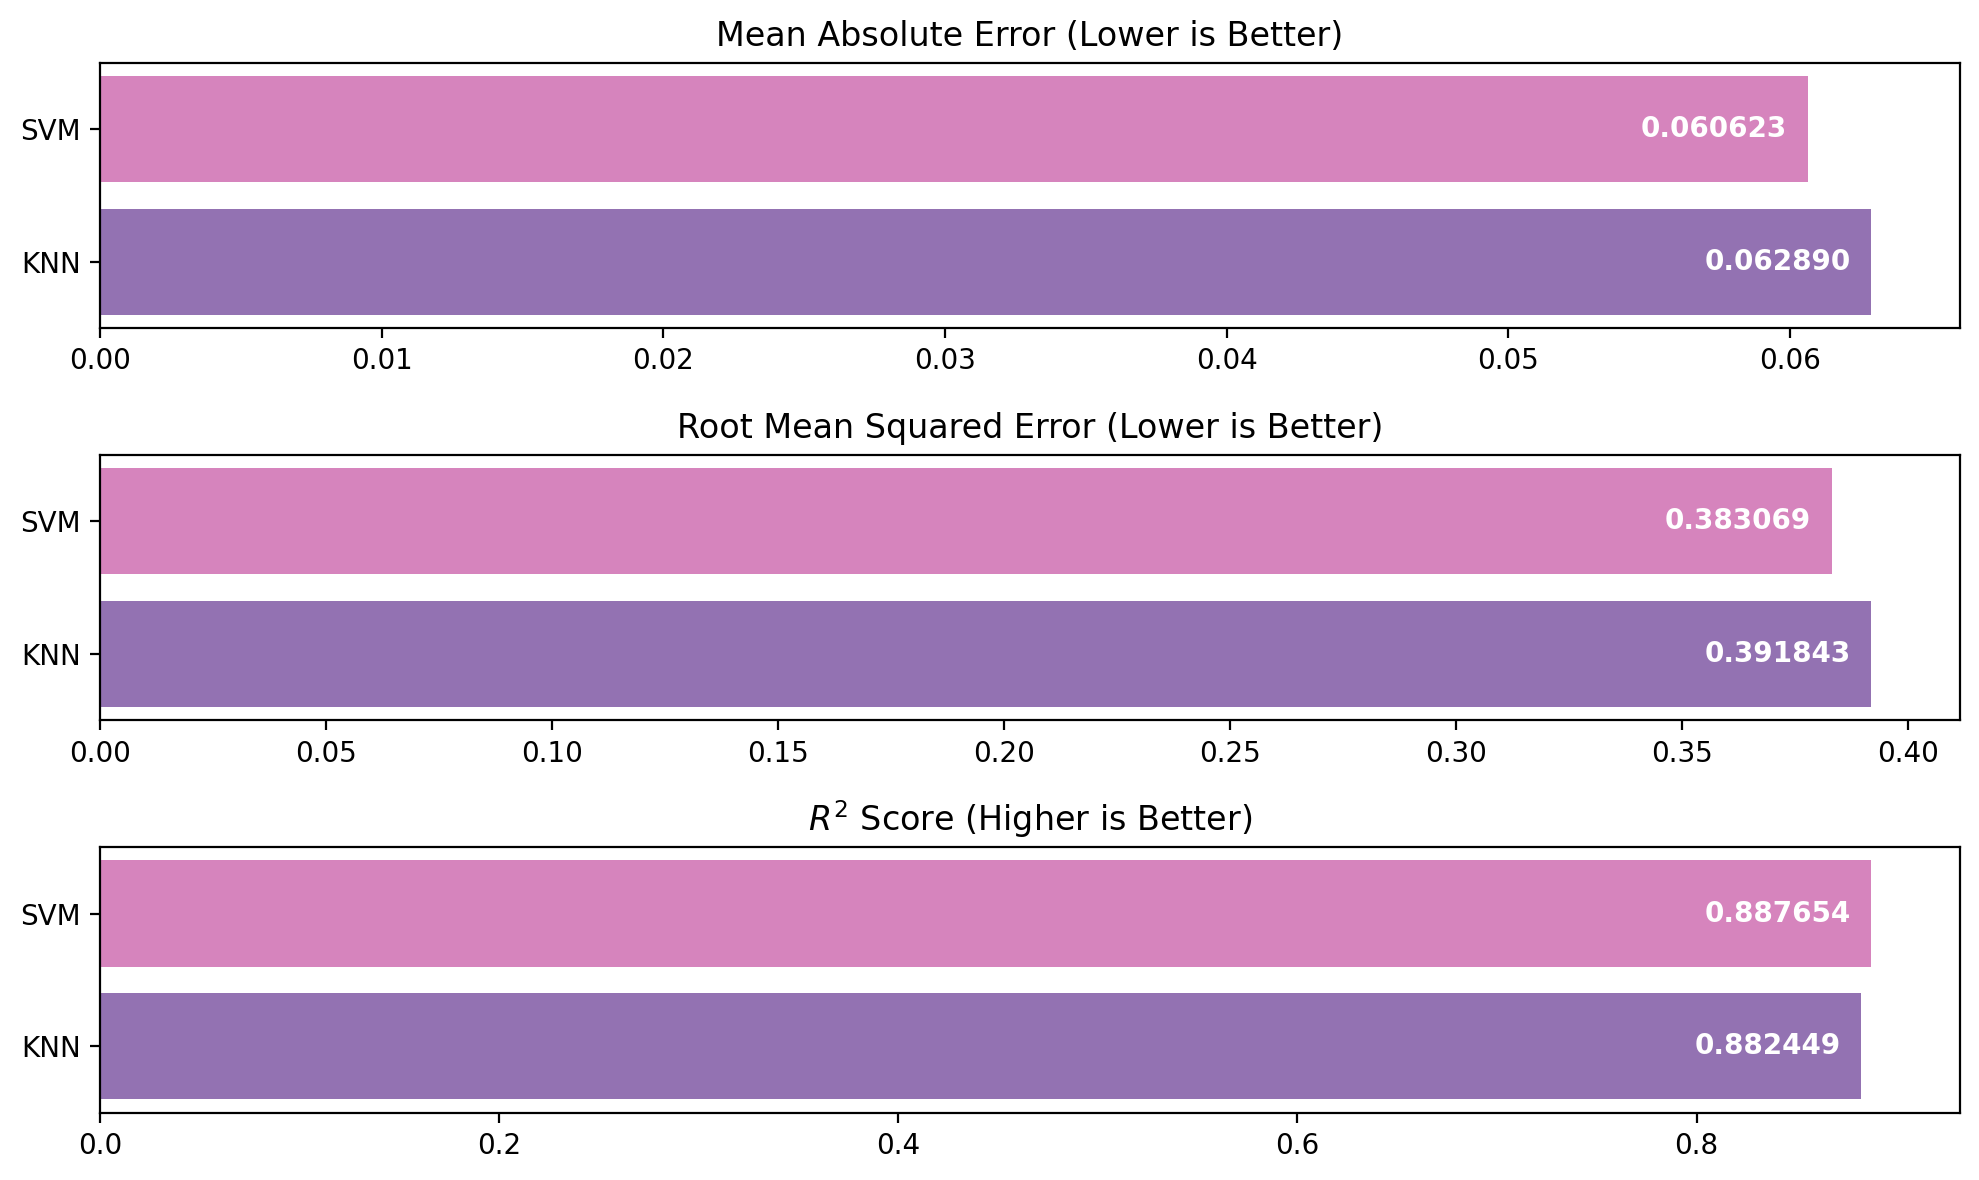

In [40]:
# Visualization

fig,ax = plt.subplots(figsize=(10,6),dpi=200,nrows=3,ncols=1)

barplot = sns.barplot(
    x=[mean_absolute_error(y_test,y_pred_svm),mean_absolute_error(y_test,y_pred_knn)],
    y=["SVM", "KNN"],
    palette=['#e377c2','#9467bd'],
    ax=ax[0]
)
for i in barplot.containers:
    barplot.bar_label(i,fmt="%.6f",padding=-60,color="white",fontweight="bold")
ax[0].set_title("Mean Absolute Error (Lower is Better)")

barplot = sns.barplot(
    x=[np.sqrt(mean_squared_error(y_test,y_pred_svm)),np.sqrt(mean_squared_error(y_test,y_pred_knn))],
    y=["SVM", "KNN"],
    palette=['#e377c2','#9467bd'],
    ax=ax[1]
)
for i in barplot.containers:
    barplot.bar_label(i,fmt="%.6f",padding=-60,color="white",fontweight="bold")
ax[1].set_title("Root Mean Squared Error (Lower is Better)")

barplot = sns.barplot(
    x=[r2_score(y_test,y_pred_svm),r2_score(y_test,y_pred_knn)],
    y=["SVM", "KNN"],
    palette=['#e377c2','#9467bd'],
    ax=ax[2]
)
for i in barplot.containers:
    barplot.bar_label(i,fmt="%.6f",padding=-60,color="white",fontweight="bold")
ax[2].set_title("$ R^{2} $ Score (Higher is Better)")

plt.tight_layout()
plt.show()

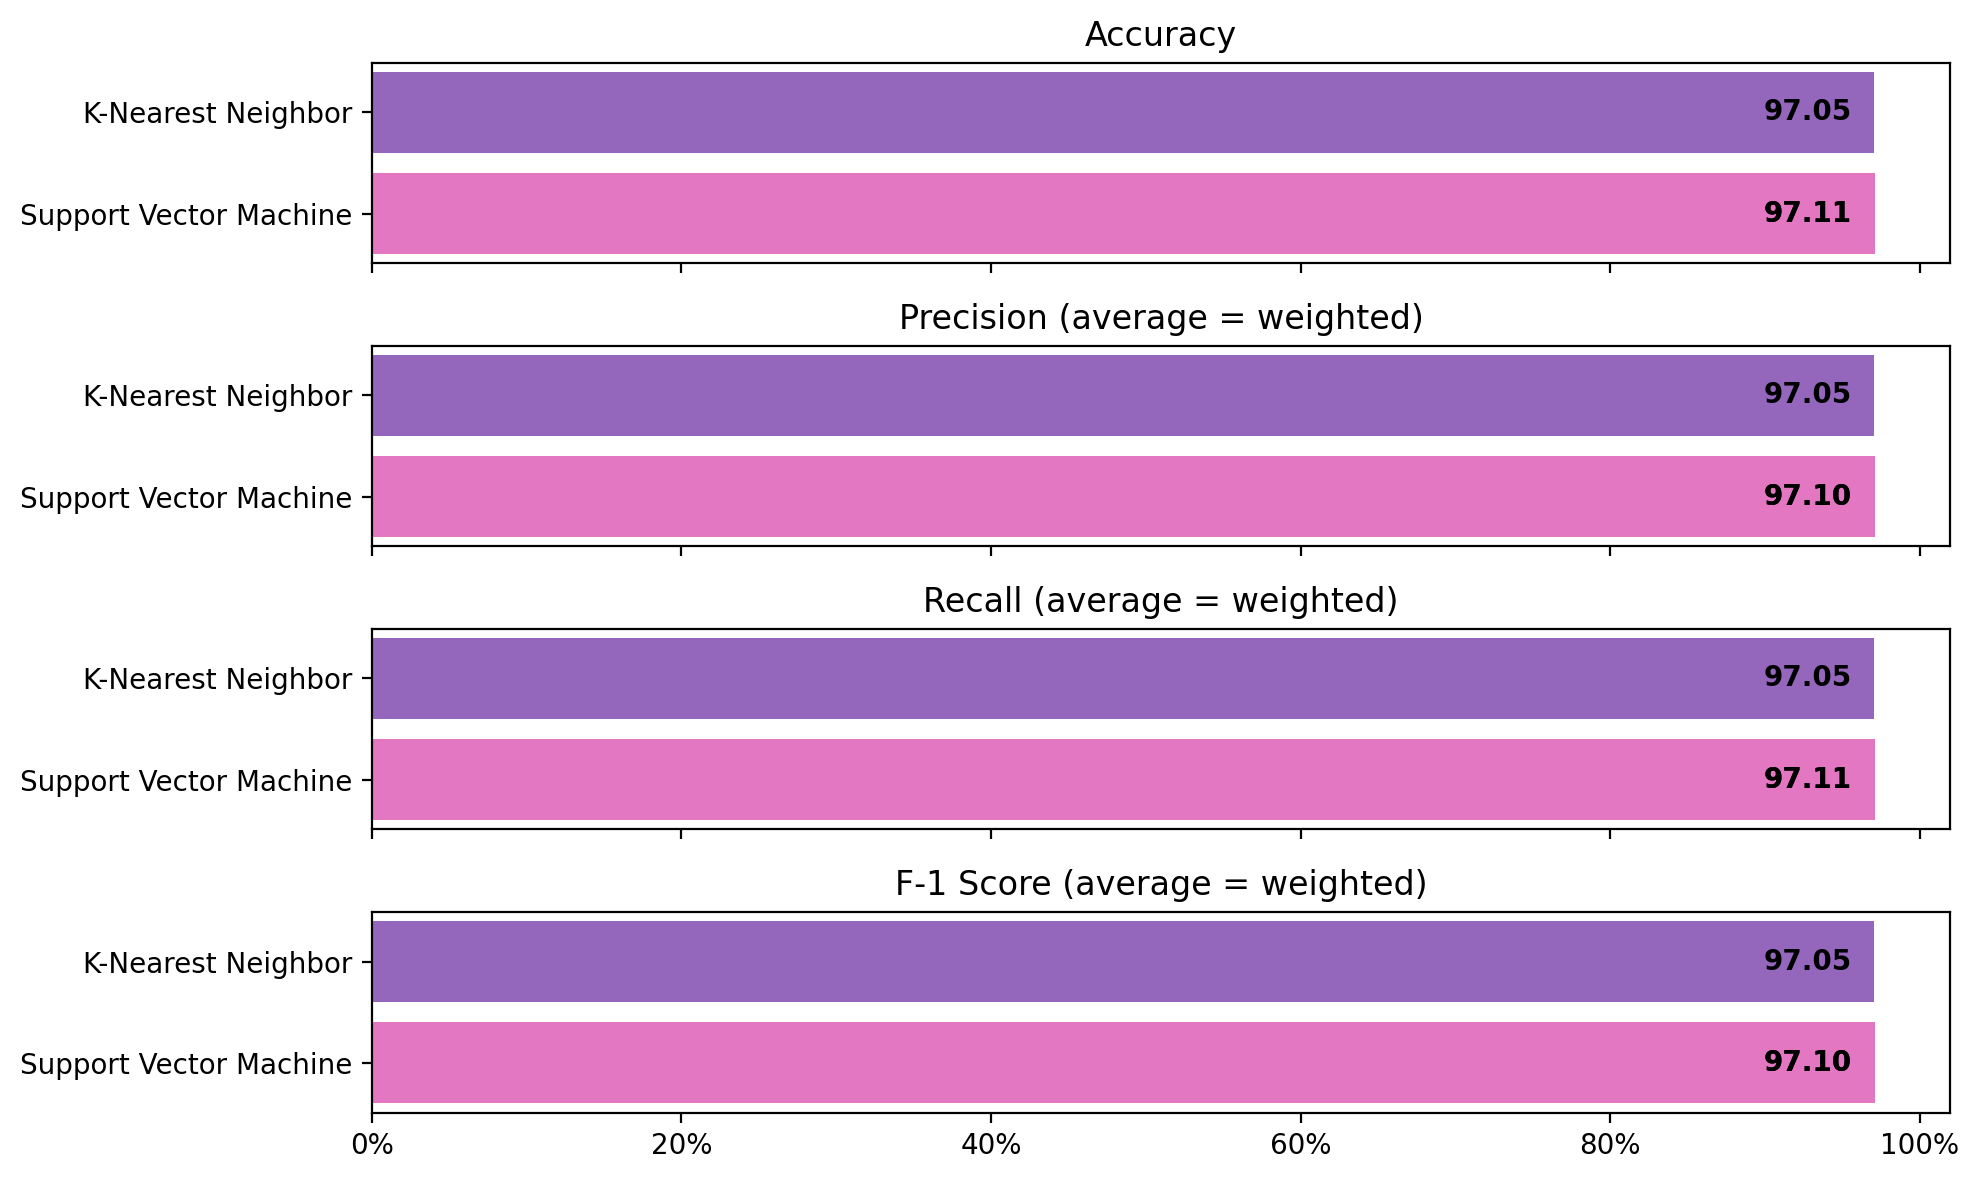

In [41]:
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming y_pred_svm, y_pred_knn, y_test are defined elsewhere in your code

nrows, ncols = 4, 1
fig, ax = plt.subplots(figsize=(10, 6), dpi=200, nrows=nrows, ncols=ncols, sharex=True)

metrics = []

for j, k, l in zip(
    [y_pred_svm, y_pred_knn],
    ["Support Vector Machine", "K-Nearest Neighbor"],
    ['#e377c2','#9467bd']
):
    for i in range(nrows):
        if i == 0:
            metric = accuracy_score(y_test, j) * 100
            title = "Accuracy"
        elif i == 1:
            metric = precision_score(y_test, j, average="weighted") * 100
            title = "Precision (average = weighted)"
        elif i == 2:
            metric = recall_score(y_test, j, average="weighted") * 100
            title = "Recall (average = weighted)"
        else:
            metric = f1_score(y_test, j, average="weighted") * 100
            title = "F-1 Score (average = weighted)"

        ax[i].barh(k, metric, color=l)
        ax[i].set_title(title)

        for container in ax[i].containers:
            ax[i].bar_label(container, fmt="%.2f", padding=-40, color="black", fontweight="bold")

        ax[i].xaxis.set_major_formatter(tick.FuncFormatter(lambda x, _: f"{round(x)}%"))

plt.tight_layout()
plt.show()

# Kesimpulan
Dari analisa di atas dapat ditarik beberapa kesimpulan bahwa Metode pengujian menggunakan 2 model yaitu Support Vector Machine dan K-Nearest Neighbor. Berdasarkan nilai R-Square diperoleh akurasi masing-masing 86.65% dan 96.44%. Hal ini menunjukkan Model K-Nearest Neighbor merupakan model yang paling optimal dengan RMSE sebesar 0.220681 dan nilai MAE sebesar 0.021560.